## Contents
- [Imports](#Imports)
- [Merging Uber & Lyft Datasets](#Merging-Uber-&-Lyft-Datasets)
- [Cleaning Up Dataset](#Cleaning-Up-Dataset)
- [Preprocessing](#Preprocessor-to-All-Text)
- [Stopwords](#Stopwords)
- [Pipelines & Gridsearches](#Pipelines-&-Gridsearches)
    - [Unprocessed "all_text"](#Unprocessed-"all_text")
    - [Lemmatized "all_text"](#Lemmatized-"all_text")
    - [Porter Stemmed "all_text"](#Porter-Stemmed-"all_text")
    - [TokTok Tokenized "all_text"](#TokTok-Tokenized-"all_text")
    - [Snowball Stemmed "all_text"](#Snowball-Stemmed-"all_text")
- [ROC/AUC Curve for Best Model](#ROC/AUC-Curve)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Inference](#Inference)
- [Bi-gram Stopwords](#Bi-grams-Stopwords)
    

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB, BernoulliNB

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 

import regex as re

from scipy.stats import ttest_ind

## Merging Uber & Lyft Datasets

In [2]:
os.listdir()

['.DS_Store',
 'projectREADME.md',
 'Requirements.txt',
 'README.md',
 'data_csv',
 'Reddit - Webscraping.ipynb',
 '.gitignore',
 'Reddit - NLP EDA.ipynb',
 '.ipynb_checkpoints',
 'reddit_creds.json',
 '.git']

In [3]:
pwd

'/Users/Work/Documents/github/ga/projects/project_3'

In [4]:
df_names_ls = [file.split('_')[0] for file in os.listdir('data_csv')[1:]]

In [5]:
df_names_ls

['uber20191010',
 'uber20191013',
 'lyft20191009',
 'master',
 'lyft20191010',
 'lyft20191013',
 'uber20191009']

In [6]:
file_paths = ['./data_csv/' + str(name) for name in os.listdir('data_csv')[1:]]

In [7]:
file_paths

['./data_csv/uber20191010_10_59.csv',
 './data_csv/uber20191013_14_44.csv',
 './data_csv/lyft20191009_22_08.csv',
 './data_csv/master_df.csv',
 './data_csv/lyft20191010_10_59.csv',
 './data_csv/lyft20191013_14_44.csv',
 './data_csv/uber20191009_22_08.csv']

In [8]:
master_cols = {
    'title': [],
    'num_comments': [],
    'elapsed_time': [],
    'subreddit': [],
    'body': [],
    'comments': []
}


master_df = pd.DataFrame(master_cols)

master_df.head()

,title,num_comments,elapsed_time,subreddit,body,comments


In [9]:

for file_path in file_paths:
    
    master_df = pd.concat([master_df, pd.read_csv(file_path)])

master_df.head()

/Users/Work/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,all_text,body,comments,elapsed_time,num_comments,subreddit,target,title
0,NaN,(tl;dr - a driver touched me sexually last wee...,NaN,0.008974,0.0,uber,NaN,Procedure On Making An Incident Report On Sexu...
1,NaN,"(TL;DR: Uber malfunctions, overcharges me, and...",Uber lacks Tegridy Uber will fuck you anyway t...,0.090444,5.0,uber,NaN,This is the AVOID UBER AT ALL COSTS post you m...
2,NaN,I wanted to share a recent experience I had wi...,You're fucked. If the cops don't care (which ...,0.195074,13.0,uber,NaN,Uber needs a better way to contact drivers
3,NaN,No coordination at all. None of the Ubers tha...,Yeah you learn quick. I will never do some lar...,0.529877,4.0,uber,NaN,"Hey Uber, your Dodger Stadium setup is absolut..."
4,NaN,Image,I am surprised that you are the only one talki...,0.560190,4.0,uber,NaN,Uber losses slam stock of James River as insur...


## Cleaning Up Dataset

In [10]:
master_df.shape

(8019, 8)

In [11]:
# Dropping duplicates by keeping latest webscrape

master_df = master_df.sort_values(['title',
                       'elapsed_time', 'num_comments'],
                      ascending = False).drop_duplicates(subset = ['title', 'body'],
                                                         keep ='first')


In [12]:
master_df.shape

(2135, 8)

In [13]:
master_df.isna().sum()

all_text        1061
body              77
comments          44
elapsed_time       0
num_comments       0
subreddit          0
target          1061
title              0
dtype: int64

In [14]:
# Replace No body texts with spaces

master_df.loc[master_df['body'].isna(), ['body']] = ' '

In [15]:
# Replace No comments with spaces

master_df.loc[master_df['comments'].isna(), ['comments']] = ' '

In [16]:
master_df.isna().sum()

all_text        1061
body               0
comments           0
elapsed_time       0
num_comments       0
subreddit          0
target          1061
title              0
dtype: int64

In [17]:
master_df['subreddit'].value_counts()

Lyft    1070
uber    1065
Name: subreddit, dtype: int64

In [18]:
master_df['all_text'] = master_df['title'] + master_df['body'] + master_df['comments']

In [19]:
# Creating target column
# uber = 1, lyft = 0

master_df['target'] = master_df['subreddit'].replace({'uber':1,
                               'Lyft': 0})

In [20]:
# Confirming balanced targets
# Baseline Score: essentially a coin flip between the two targets

master_df['target'].value_counts(normalize = True)

0    0.501171
1    0.498829
Name: target, dtype: float64

In [21]:
master_df.head(3)

,all_text,body,comments,elapsed_time,num_comments,subreddit,target,title
739,"“You’re in a busy area, expect trips soon”Is t...",Is this a glitch? Its been stuck on this for l...,I don't know if it's a glitch or not but I do ...,77.615237,1.0,uber,1,"“You’re in a busy area, expect trips soon”"
9,“We can squeeze in!”I drive an Uber X and got ...,I drive an Uber X and got a ping last night. P...,I once had to leave a group of five in the rai...,0.811718,3.0,uber,1,“We can squeeze in!”
2,“New” riders on Lyft are not new at all!I’ve n...,I’ve noticed a lot of “New” riders on Lyft lat...,People create new accounts by using multiple m...,23.800846,23.0,Lyft,0,“New” riders on Lyft are not new at all!


### Preprocessor to All Text

In [22]:
lemmatizer = WordNetLemmatizer()
toktok = ToktokTokenizer()
port_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('english')

In [23]:
# Removing punctuation from all text before preprocessing

master_df['alltxt_punc_remove'] = [re.sub("[^a-zA-Z]", " ", post) for post in master_df['all_text']]

In [25]:
# Lemmatizing all_text

clean_post_list = []

for post in master_df['alltxt_punc_remove']:
    
    clean_word_list = []
    
    for word in post.split(' '):
        clean_word = lemmatizer.lemmatize(word).lower()
        clean_word_list.append(clean_word)
    
    clean_post_list.append(" ".join(clean_word_list))

master_df['alltxt_lemmatize'] = clean_post_list

In [27]:
# TokTok Tokenizing all_text
clean_post_list = []

for post in master_df['alltxt_punc_remove']:
    
    clean_word_list = []
    
    for word in post.split(' '):
        clean_word = toktok.tokenize(word.lower())
        
        for item in clean_word:
            
            if type(item) == str:
                clean_word_list.append(item)

    
    clean_post_list.append(" ".join(clean_word_list))
    
master_df['alltxt_toktok'] = clean_post_list

In [28]:
# Porter Stemming all_text
clean_post_list = []

for post in master_df['alltxt_punc_remove']:
    
    clean_word_list = []
    
    for word in post.split(' '):
        clean_word = port_stemmer.stem(word).lower()
        clean_word_list.append(clean_word)
    
    clean_post_list.append(" ".join(clean_word_list))
    
master_df['alltxt_porter'] = clean_post_list

In [29]:
# Snowball Stemming all_text

clean_post_list = []

for post in master_df['alltxt_punc_remove']:
    
    clean_word_list = []
    
    for word in post.split(' '):
        clean_word = snowball_stemmer.stem(word).lower()
        clean_word_list.append(clean_word)
    
    clean_post_list.append(" ".join(clean_word_list))
    
master_df['alltxt_snowball'] = clean_post_list

### Stopwords

In [30]:
# Stop Words Lists

custom_stopwords_ls = ['uber',
                       'lyft',
                      'https',
                      'com',
                      'www',
                      'amazon',
                       'the',
                       'you',
                       'of',
                       'sure'
                      ]

no_sw_ls = ['uber',
           'lyft']

keep_ls = ['no', 'not']

for word in stopwords.words('english'):
    if word in keep_ls:
        pass
    else:
        custom_stopwords_ls.append(word)

## Pipelines & Gridsearches
- Included & adjusted a wide variety of paramateres initially.
- Narrowed down on the parameters based on different best_params_ for each different model to shorten runtime.

### Unprocessed "all_text"

In [31]:
# Train-Test Splitting
X = master_df['all_text']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])



# Pipe Parameters
pipe_cvec_params = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_tfidf_params = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}


# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_params, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_params, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_params, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_params, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.6096189881324172
gs1a Best GridSearch (cv = 5) Score: 0.6246096189881324
gs2 Best GridSearch (cv = 5) Score: 0.6083697688944409
gs2a Best GridSearch (cv = 5) Score: 0.6114928169893816


### Porter Stemmed "all_text"

In [33]:
# Train-Test Splitting
X = master_df['alltxt_porter']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])



# Pipe Parameters
pipe_cvec_params = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_tfidf_params = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}


# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_params, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_params, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_params, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_params, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.5921299188007495
gs1a Best GridSearch (cv = 5) Score: 0.6202373516552155
gs2 Best GridSearch (cv = 5) Score: 0.6127420362273579
gs2a Best GridSearch (cv = 5) Score: 0.6108682073703935


### TokTok Tokenized "all_text"

In [36]:
# Train-Test Splitting
X = master_df['alltxt_toktok']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])



# Pipe Parameters
pipe_cvec_params = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_tfidf_params = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}


# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_params, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_params, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_params, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_params, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.6102435977514054
gs1a Best GridSearch (cv = 5) Score: 0.6246096189881324
gs2 Best GridSearch (cv = 5) Score: 0.6127420362273579
gs2a Best GridSearch (cv = 5) Score: 0.6146158650843223


### Snowball Stemmed "all_text"

In [37]:
# Train-Test Splitting
X = master_df['alltxt_snowball']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])



# Pipe Parameters
pipe_cvec_params = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_tfidf_params = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}


# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_params, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_params, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_params, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_params, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.6058713304184884
gs1a Best GridSearch (cv = 5) Score: 0.63210493441599
gs2 Best GridSearch (cv = 5) Score: 0.6121174266083698
gs2a Best GridSearch (cv = 5) Score: 0.6139912554653342


### Lemmatized "all_text"

In [38]:
# Train-Test Splitting
# Including LogReg parameters made no significant 
# impact on my accuracy scores
# so in order to improve run time, they will be excluded

X = master_df['alltxt_lemmatize']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])



# Pipe Parameters
pipe_cvec_paramsNB = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_cvec_paramsLR = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
#     'logreg__C': [10e-2,10e-3,10e-4,10e-5,10e-6,10e-7,10e-8,10e-9,10e-10,10e-11],
#     'logreg__penalty': ['l1','l2'],
}

pipe_tfidf_paramsLR = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
#     'logreg__C': [10e-2,10e-3,10e-4,10e-5,10e-6,10e-7,10e-8,10e-9,10e-10,10e-11],
#     'logreg__penalty': ['l1','l2']
}

pipe_tfidf_paramsNB = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}

# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_paramsLR, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_paramsLR, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_paramsNB, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_paramsNB, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.622735790131168
gs1a Best GridSearch (cv = 5) Score: 0.637101811367895
gs2 Best GridSearch (cv = 5) Score: 0.6189881324172393
gs2a Best GridSearch (cv = 5) Score: 0.6246096189881324


## Best Model:
- Lemmatizing
- TfidfVectorize
- Logistic Regression Model

In [39]:
print(f'Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'Best model\'s score on Train: {gs1a.best_estimator_.score(X_train, y_train)}')
print(f'Best model\'s score on Test: {gs1a.best_estimator_.score(X_test, y_test)}')

gs1a_model = gs1a.best_estimator_

Best GridSearch (cv = 5) Score: 0.637101811367895
Best model's score on Train: 0.787632729544035
Best model's score on Test: 0.6591760299625468


In [40]:
# Features used in the best model
feature_names = gs1a_model.named_steps['tfidf'].get_feature_names()


# Making dataframe with matrix & feature names
term_matrix = gs1a_model.named_steps['tfidf'].fit_transform(X_train)

term_df = pd.DataFrame(term_matrix.toarray(),
                      columns = feature_names)

term_df['target'] = y_train.values

freq_dict = {word: term_df[word].sum() for word in feature_names}


# Making dataframe with features and sum of counts
freq_df = pd.DataFrame(freq_dict, index = ['counts'])
freq_df = freq_df.T
freq_df.sort_values('counts', ascending = False).head(3)

,counts
credit card,23.251170
phone number,22.740518
get ride,22.303582


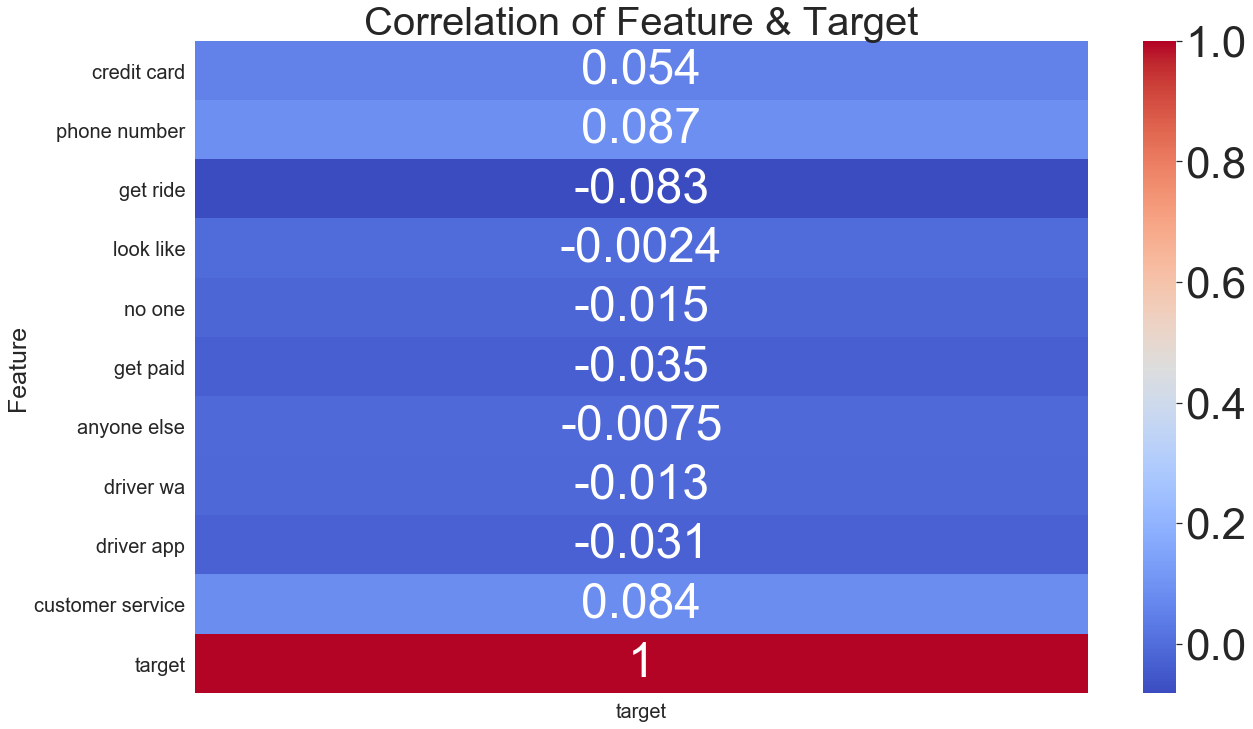

In [161]:
# Heatmap of top occurring 10 features
top_10 = list(freq_df.sort_values('counts', ascending = False).head(10).index)
top_10.append('target')

corr = term_df[top_10].corr()

plt.figure(figsize = (20,12))
ax = sns.heatmap(corr[['target']], annot=True, cmap = 'coolwarm')

ax.set_ylabel('Feature', fontsize = 25.0)
ax.set_title('Correlation of Feature & Target', fontsize = 40)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20, labelrotation=0)
sns.set(font_scale=1);

This heatmap shows the correlation of the top 10 occurring features in the entire dataframe. All these features have a correlation of around 0 to the target.

### ROC/AUC Curve

In [42]:
# Getting predictions

preds = gs1a_model.predict(X_test)

In [43]:
# Confusion Matrix

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [44]:
# False Positive Rate
# fp / fp + tn

fp / (fp+tn)

0.3203125

In [45]:
# True Positive Rate
# tp / tp + fn

tp / (tp + fn)

0.6402877697841727

In [46]:
# Another way to get FPR and TPR

fpr, tpr, threshold = roc_curve(y_test, preds)

In [47]:
# AUC

roc_auc = auc(fpr, tpr)
roc_auc.round(2)

0.66

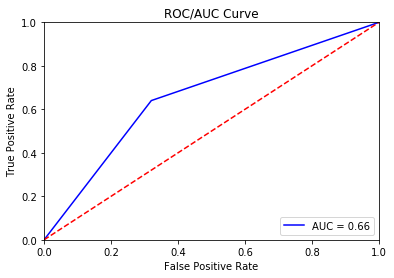

In [48]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

plt.title('ROC/AUC Curve')
plt.plot(fpr, tpr, color = 'blue', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

This ROC/AUC curve is for one false positive rate and true positive rate at the 50% threshold. The model is better than a 50/50 coin toss but it's not that great overall. False positives occur at almost a 40% rate.

In [49]:
# Top Uber Correlations
top5_corr = term_df.corr().sort_values('target', ascending = False).head(5)

In [50]:
# Top Lyft Correlations
low5_corr = term_df.corr().sort_values('target', ascending = True).head(5)

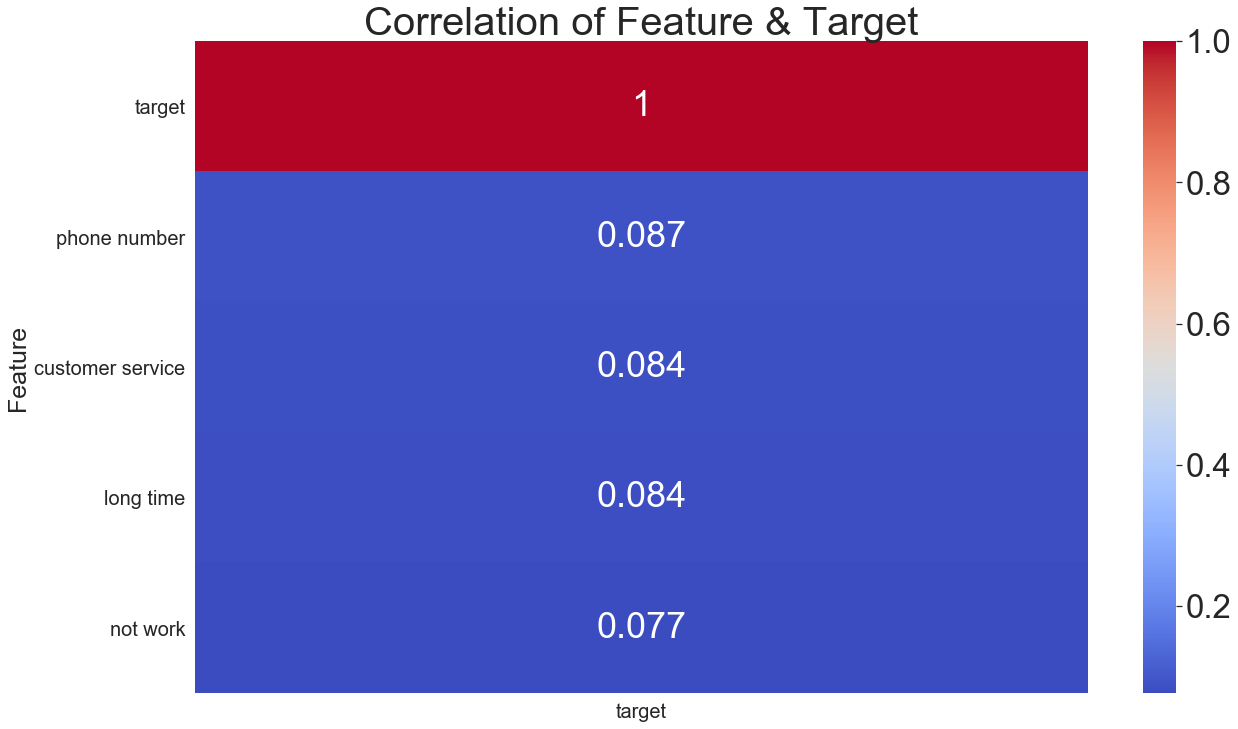

In [160]:
# Features most correlated with Uber

plt.figure(figsize = (20,12))
ax = sns.heatmap(top5_corr[['target']], annot=True, cmap = 'coolwarm')


ax.set_ylabel('Feature', fontsize = 25.0)
ax.set_title('Correlation of Feature & Target', fontsize = 40)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20, labelrotation=0)
sns.set(font_scale=4);

This heatmap shows the top 5 correlation values and their features. These features are the ones that are most correlated to Uber.

Note that the "top" isn't really that high.

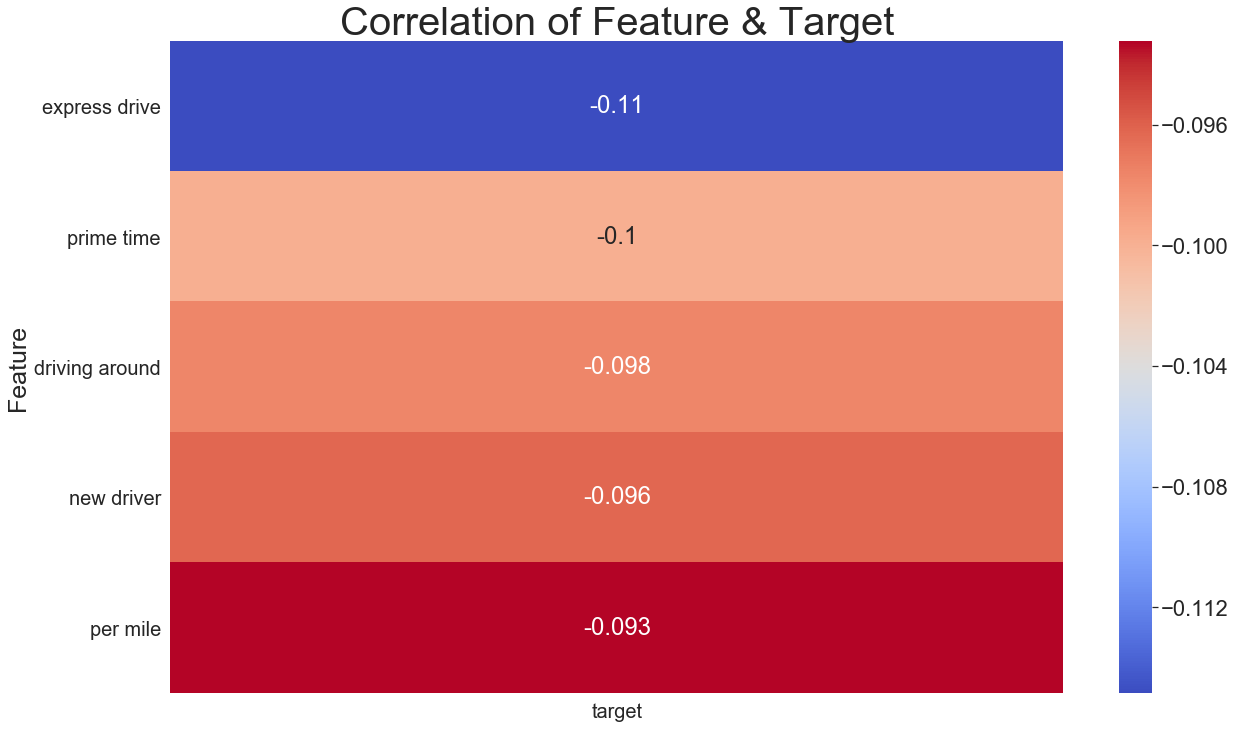

In [148]:
# Features most correlated with Lyft

plt.figure(figsize = (20,12))
ax = sns.heatmap(low5_corr[['target']], annot=True, cmap = 'coolwarm')

ax.set_ylabel('Feature', fontsize = 25.0)
ax.set_title('Correlation of Feature & Target', fontsize = 40)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20, labelrotation=0)
sns.set(font_scale=1);

This heatmap shows the lowest 5 correlation values and their features. These features are the ones that are most correlated to Lyft.

Note that the "lowest" isn't really that low.

### Sentiment Analysis
- Polarity scores have proven to be inaccurate.
    - A lot negative posts are read as positive and vice versa.
- **Will not be included in final conclusions, but is presented here to show that it has been considered**

In [53]:
# Instantiating sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [54]:
# Functions to get certain attributes of the polarity scores.

def get_compound(text):
    return sia.polarity_scores(text)['compound']

def get_neg(text):
    return sia.polarity_scores(text)['neg']

def get_pos(text):
    return sia.polarity_scores(text)['pos']

In [55]:
# Compound scores of all submissions for comments ONLY
# added to dataframe

master_df['sentiment_comments'] = master_df['comments'].apply(get_compound)

In [56]:
# Uber compound scores for comments only

uber_sentiment_comments_df = master_df.loc[(master_df['subreddit'] == 'uber') & (master_df['sentiment_comments']),
             ['subreddit', 'sentiment_comments']]

In [57]:
# Lyft compound scores of comments only
lyft_sentiment_comments_df = master_df.loc[(master_df['subreddit'] == 'Lyft') & (master_df['sentiment_comments']),
             ['subreddit', 'sentiment_comments']]

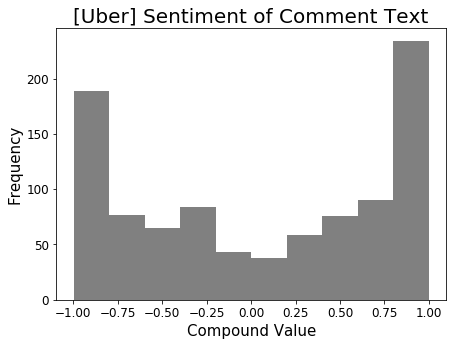

In [58]:
plt.figure(figsize=(7,5))
plt.hist(uber_sentiment_comments_df['sentiment_comments'],
        color = 'gray')

plt.title('[Uber] Sentiment of Comment Text', fontsize=20)
plt.xlabel('Compound Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

Frequency of compound polarity scores of only the comment texts of subreddits that belong to Uber. These are pretty inaccurate because after going on Reddit and reading them, they are actually negative.

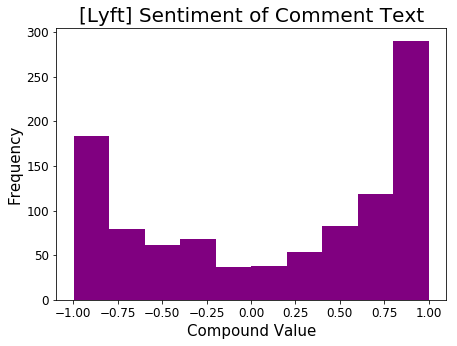

In [59]:
plt.figure(figsize=(7,5))
plt.hist(lyft_sentiment_comments_df['sentiment_comments'],
        color = 'purple')

plt.title('[Lyft] Sentiment of Comment Text', fontsize=20)
plt.xlabel('Compound Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

Frequency of compound polarity scores of only the **comment texts** of subreddits that belong to Lyft. These are pretty inaccurate because after going on Reddit and reading them, they are actually negative.

In [60]:
# Compound scores of body text ONLY
# added to dataframe

master_df['sentiment_body'] = master_df['body'].apply(get_compound)

In [61]:
# Uber compound scores of body only
uber_sentiment_body_df = master_df.loc[(master_df['subreddit'] == 'uber') & (master_df['sentiment_comments']),
             ['subreddit', 'sentiment_body']]

In [62]:
# Lyft compound scores of body only
lyft_sentiment_body_df = master_df.loc[(master_df['subreddit'] == 'Lyft') & (master_df['sentiment_comments']),
             ['subreddit', 'sentiment_body']]

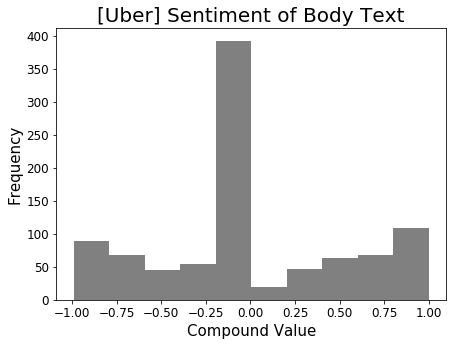

In [63]:
plt.figure(figsize=(7,5))
plt.hist(uber_sentiment_body_df['sentiment_body'],
        color = 'gray')

plt.title('[Uber] Sentiment of Body Text', fontsize=20)
plt.xlabel('Compound Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

Frequency of compound polarity scores of only the **body texts** of subreddits that belong to Uber. After getting terrible scores from the sentiment analysis for the comments, I am unsure how reliable these polarity scores are for my Subreddits.

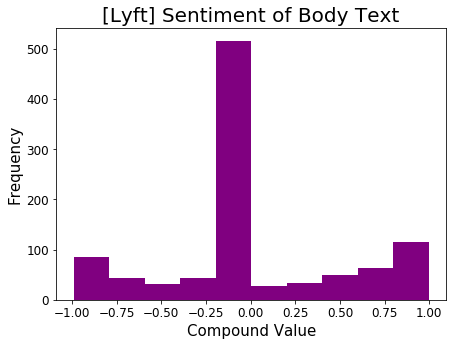

In [64]:
plt.figure(figsize=(7,5))
plt.hist(lyft_sentiment_body_df['sentiment_body'],
        color = 'purple')

plt.title('[Lyft] Sentiment of Body Text', fontsize=20)
plt.xlabel('Compound Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

Frequency of compound polarity scores of only the **body texts** of subreddits that belong to Lyft. After getting terrible scores from the sentiment analysis for the comments, I am unsure how reliable these polarity scores are for my Subreddits.

### Inference

In [65]:
# Creating dataframe of feature and exponentiated logreg model coefs

best_model = {
    'exp.coef': [],
    'feature': [],
}


best_model_df = pd.DataFrame(best_model)

best_model_df['exp.coef'] = list(np.exp(gs1a_model.named_steps['logreg'].coef_[0]))

best_model_df['feature'] = gs1a_model.named_steps['tfidf'].get_feature_names()

# Highest coefficient weights
best_model_df.sort_values('exp.coef', ascending = False).head(3)

,exp.coef,feature
222,4.199912,long time
214,4.188884,license plate
55,3.867137,customer service


In [66]:
# Lowest coefficient weights
best_model_df.sort_values('exp.coef', ascending = True).head(3)

,exp.coef,feature
124,0.121077,express drive
347,0.159133,prime time
268,0.192240,new driver


In [67]:
# Features with logreg exp.coef weights between 0.9>x>1.1
# potential stop words

stop_features = best_model_df.loc[(best_model_df['exp.coef'] > 0.9) & (best_model_df['exp.coef'] < 1.1)]

In [68]:
# creating list of potential stop words
# adding these words to custom stopwords decreased accuracy of model

sw_to_add = list(stop_features.sort_values('exp.coef')['feature'])
len(sw_to_add)

69

In [69]:
# Sum of TFIDF Matrix turned into dataframe

best_model_sum = term_df.groupby('target').sum().T

In [70]:
# Resetting index to numbers

best_model_sum.reset_index(inplace = True)

In [71]:
# Renaming columns 

best_model_sum.columns = ['feature', 0, 1]

In [72]:
# Dataframe with matrix sums

best_model_sum = best_model_sum.sort_values('feature')

In [73]:
# Dataframe with coefs
best_model_df = best_model_df.sort_values('feature')

In [74]:
# Combining the two dataframes
feature_prop_coef = best_model_sum.merge(best_model_df, left_on = 'feature', right_on = 'feature')

In [94]:
# Grabbed features with most positive exp.coef weights
# head(3) added for Git viewability
feature_prop_coef[feature_prop_coef['exp.coef'] > 2].sort_values('exp.coef', ascending = False).head(3)

,feature,0,1,exp.coef
222,long time,0.761482,6.097763,4.199912
214,license plate,3.030606,10.910283,4.188884
55,customer service,4.954755,14.683183,3.867137


In [76]:
# 14 interesting uber features
uber_interesting = ['long time', 'license plate', 'customer service', 'driver make','driver get','driver take','phone number','payment method','schedule ride','food delivery','star rating','bad rating','pickup point','tip tip']

In [77]:
# Making dataframe with interesting terms

coef_positive_df = feature_prop_coef[feature_prop_coef['feature'].isin(uber_interesting)]

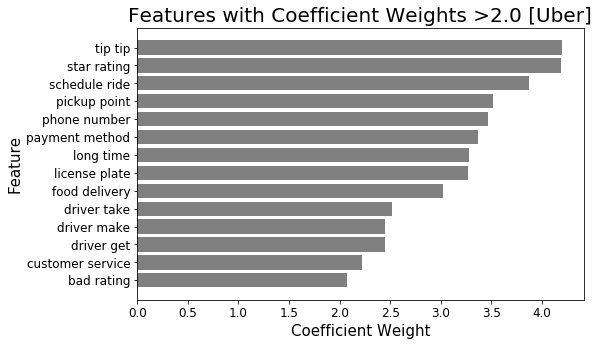

In [103]:
plt.figure(figsize=(8,5))
plt.barh(width = coef_positive_df.sort_values('exp.coef', ascending = True)['exp.coef'],
         y = coef_positive_df['feature'],
        color='gray')

plt.title('Features with Coefficient Weights >2.0 [Uber]', fontsize=20)
plt.xlabel('Coefficient Weight', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

The bar graph displays some interesting bi-grams that have a coefficient weight greater than 2. "tip" and "star" makes the probability around 4x as likely for the target to be Uber.  

Passengers are asking if they should tip, drivers complaining about not getting tips. People talking about different things that may/may not affect their rating as a rider/driver.

In [93]:
# Grabbed features with lowest exp.coef weights
# head(3) added for Git viewability

feature_prop_coef[feature_prop_coef['exp.coef'] < 0.5].sort_values('exp.coef', ascending = True).head(3)

,feature,0,1,exp.coef
124,express drive,14.822742,0.450318,0.121077
347,prime time,8.867941,0.242066,0.159133
268,new driver,10.881708,2.203045,0.192240


In [80]:
# 12 interesting Lyft features
lyft_interesting = ['express drive', 'prime time', 'new driver', 'background check', 'shared ride', 'ride history', 'insurance company', 'accept ride', 'ride share', 'san diego','los angeles','no show']

In [81]:
# Making dataframe with interesting terms
coef_negative_df = feature_prop_coef[feature_prop_coef['feature'].isin(lyft_interesting)]

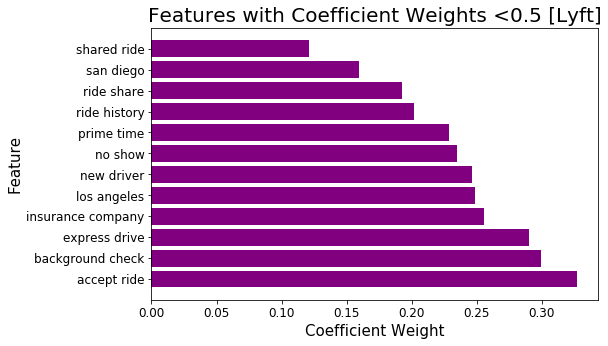

In [105]:
plt.figure(figsize=(8,5))
plt.barh(width = coef_negative_df.sort_values('exp.coef', ascending = False)['exp.coef'],
         y = coef_negative_df['feature'],
        color = 'purple')

plt.title('Features with Coefficient Weights <0.5 [Lyft]', fontsize=20)
plt.xlabel('Coefficient Weight', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

The bar graph displays some interesting bi-grams that have a coefficient weight less than 0.5. "shared ride" and "san diego" makes the probability around 0.1x as likely for the target to be Uber (so more likely to be Lyft).

People are complaining about shared rides (poor route, adds a lot of time, desire to turn it off as a driver, etc.). A lot of the people talking on the Lyft subreddit are drivers/riders in San Diego.

In [106]:
# Grabbed features with exp.coef weights between 0.9 and 1.1
# head(3) added for Git viewability--there's 62 rows total.
feature_prop_coef[(feature_prop_coef['exp.coef'] > 0.9) & (feature_prop_coef['exp.coef'] < 1.1)].head(3)

,feature,0,1,exp.coef
18,app not,4.530065,4.222069,1.025363
19,ask driver,2.569543,2.776491,0.955676
24,bad driver,2.098827,1.872236,1.053644


In [116]:
# 10 interesting feature with 0.9>exp.coef>1.1
interesting = ['app not', 'contact support', 'dispute charge', 'every ride', 'first ride','get free','pickup location', 'ride airport', 'saturday night', 'tip get']

In [117]:
# Making dataframe with interesting terms
coef_1_df = feature_prop_coef[feature_prop_coef['feature'].isin(interesting)]

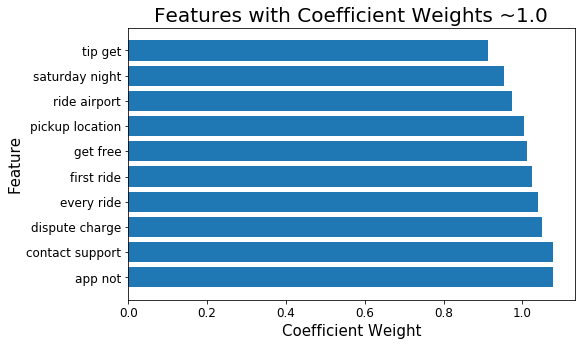

In [118]:
plt.figure(figsize=(8,5))
plt.barh(width = coef_1_df.sort_values('exp.coef',ascending=False)['exp.coef'],
         y = coef_1_df['feature'])

plt.title('Features with Coefficient Weights ~1.0', fontsize=20)
plt.xlabel('Coefficient Weight', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12);

The bar graph displays some interesting bi-grams that have a coefficient weight around 1. "pickup location" and "contact support" doesn't change the probability for the target to be Uber/Lyft, meaning these words are commonly used in both Subreddits at the same frequency.

Drivers complain about riders setting bad pickup locations.
A lot of people are complaining about the their experience with customer support and some people are asking how to contact them.



### Bi-grams Stopwords

In [88]:
bi_gram_stop_ls = ['not enough',
 'make sense',
 'driver work',
 'every time',
 'ride never',
 'look like',
 'one day',
 'ride ha',
 'told wa',
 'see driver',
 'driver going',
 'keep mind',
 'not driver',
 'wait minute',
 'dispute charge',
 'want drive',
 'driver go',
 'keep getting',
 'driver one',
 'ride airport',
 'always get',
 'last month',
 'next day',
 'lot time',
 'ask driver',
 'get back',
 'go home',
 'driver see',
 'rider driver',
 'keep driving',
 'let know',
 'doe not',
 'call support',
 'tip driver',
 'http help',
 'rental car',
 'drive car',
 'san francisco',
 'wa hour',
 'driver wa',
 'one ha',
 'not one',
 'driver always',
 'tip get',
 'no need',
 'want get',
 'get better',
 'complete ride',
 'wa wa',
 'way get',
 'know not',
 'doe anyve',
 'stopped driving',
 'couple time',
 'way back',
 'got charged',
 'hour ride',
 'last week',
 'wa still',
 'say driver',
 'pay driver',
 'ride wa',
 'ride one',
 'could not',
 'mile away',
 'driver would',
 'never used',
 'not like',
 'say no',
 'no driver',
 'get driver',
 'pretty much',
 'tell driver',
 'every ride',
 'someone else',
 'not much',
 'driver think',
 'saturday night',
 'would not',
 'would like',
 'said no',
 'many time',
 'ride would',
 'best way',
 'going get',
 'start ride',
 'something like',
 'going back',
 'let driver',
 'pickup location',
 'get home',
 'not going',
 'app not',
 'no reason',
 'not get',
 'driver never',
 'way driver',
 'try get',
 'contact support',
 'feel like',
 'ride go',
 'get another',
 'bad driver',
 'would make',
 'wait time',
 'ride request',
 'not want',
 'go ahead',
 'one wa',
 'driving car',
 'get free',
 'first ride',
 'drive mile',
 'request ride',
 'car get',
 'min ride',
 'week ago',
 'people get',
 'driver want']

In [89]:
# Removing stop words from preprocessed text
# Making new column of preprocessed text w/o stopwords in it

clean_post_list = []
for post in master_df['alltxt_lemmatize']:
    
    clean_word_list = []
    
    for word in post.split(' '):
        clean_word = lemmatizer.lemmatize(word).lower()
        clean_word_list.append(clean_word)
        joined_words = " ".join(clean_word_list)
        
        for bi_gram in bi_gram_stop_ls:
            joined_words = joined_words.replace(bi_gram, '')
            
    clean_post_list.append(joined_words)
    
master_df['best_model_stop_removed'] = clean_post_list

In [90]:
# Remodeling best model with stopwords removed

# Train-Test Splitting
X = master_df['best_model_stop_removed']
y = master_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,

                                                    random_state=42)
# Instantiating Pipelines
pipe_cvecLR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_tfidfLR = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

pipe_cvecMNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinb', MultinomialNB())
])

pipe_tfidfMNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('multinb', MultinomialNB())
])




# Pipe Parameters
pipe_cvec_paramsNB = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)]
}

pipe_cvec_paramsLR = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words': [custom_stopwords_ls, no_sw_ls],
    'cvec__max_df': [0.9],
    'cvec__min_df': [10],
    'cvec__ngram_range': [(2,4)],
#     'logreg__C': [10e-2,10e-3,10e-4,10e-5,10e-6,10e-7,10e-8,10e-9,10e-10,10e-11],
#     'logreg__penalty': ['l1','l2'],
}

pipe_tfidf_paramsLR = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)],
#     'logreg__C': [10e-2,10e-3,10e-4,10e-5,10e-6,10e-7,10e-8,10e-9,10e-10,10e-11],
#     'logreg__penalty': ['l1','l2']
}

pipe_tfidf_paramsNB = {
    'tfidf__max_features': [100, 500],
    'tfidf__stop_words': [custom_stopwords_ls, no_sw_ls],
    'tfidf__max_df': [0.9],
    'tfidf__min_df': [10],
    'tfidf__ngram_range': [(2,4)]
}


# Instantiating GridSearches
gs1 = GridSearchCV(pipe_cvecLR, pipe_cvec_paramsLR, cv = 5)
gs1a = GridSearchCV(pipe_tfidfLR, pipe_tfidf_paramsLR, cv = 5)
gs2 = GridSearchCV(pipe_cvecMNB, pipe_cvec_paramsNB, cv = 5)
gs2a = GridSearchCV(pipe_tfidfMNB, pipe_tfidf_paramsNB, cv = 5)

# Fitting 2 Logistic Regressions
gs1.fit(X_train, y_train)
gs1a.fit(X_train, y_train)


# Fitting 2 Bernoulli Naive Bayes
gs2.fit(X_train, y_train)
gs2a.fit(X_train, y_train)

print(f'gs1 Best GridSearch (cv = 5) Score: {gs1.best_score_}')
print(f'gs1a Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'gs2 Best GridSearch (cv = 5) Score: {gs2.best_score_}')
print(f'gs2a Best GridSearch (cv = 5) Score: {gs2a.best_score_}')

/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gs1 Best GridSearch (cv = 5) Score: 0.6383510306058713
gs1a Best GridSearch (cv = 5) Score: 0.6570893191755153
gs2 Best GridSearch (cv = 5) Score: 0.6252342286071205
gs2a Best GridSearch (cv = 5) Score: 0.6339787632729544


In [91]:
best_model = {
    'exp.coef': [],
    'feature': [],
}


best_model_df = pd.DataFrame(best_model)

best_model_df['exp.coef'] = list(np.exp(gs1a_model.named_steps['logreg'].coef_[0]))

best_model_df['feature'] = gs1a_model.named_steps['tfidf'].get_feature_names()





# Features with logreg exp.coef weights between 0.9>x>1.1
# potential stop words

stop_features = best_model_df.loc[(best_model_df['exp.coef'] > 0.9) & (best_model_df['exp.coef'] < 1.1)]


# creating list of potential stop words
# adding these words to custom stopwords decreased accuracy of model

sw_to_add = list(stop_features.sort_values('exp.coef')['feature'])
len(sw_to_add)

69

In [92]:
print(f'Best GridSearch (cv = 5) Score: {gs1a.best_score_}')
print(f'Best model\'s score on Train: {gs1a.best_estimator_.score(X_train, y_train)}')
print(f'Best model\'s score on Test: {gs1a.best_estimator_.score(X_test, y_test)}')

gs1a_model = gs1a.best_estimator_

Best GridSearch (cv = 5) Score: 0.6570893191755153
Best model's score on Train: 0.7951280449718926
Best model's score on Test: 0.6423220973782772


After adding the bi-gram stop words, scores are generally about the same.